## This is my attempt at implementing the RouBl algorithm

In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=0.1, init_std=0.1, alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define and initialise the trainable variational parameters for q distribtuion
        self.mean = nn.Parameter(torch.zeros(n, **factory_kwargs), requires_grad=True)
        self.cov_chol = nn.Parameter(torch.diag(prior_std*torch.ones(n, **factory_kwargs)).detach().clone().requires_grad_(True))

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ torch.transpose(cov_chol_inv, 0, 1) @ self.mean
        
        # self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_std = prior_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.zeros(self.num_params, **factory_kwargs))
        self.register_buffer('prior_cov_chol', torch.diag(prior_std*torch.ones(n, **factory_kwargs)))
        self.register_buffer('prior_cov_inv', torch.diag(1/prior_std**2 * torch.ones(n, **factory_kwargs)))

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

    # def compute_param_gradients(self, input, K=500, targets):
    #     gradients = torch.zeros(self.num_params, requires_grad=False)
    #     for k in range(K):
    #         sampled_params = self.sample_params()  # Sample from q distribution with gradient tracking
    #         output = self.forward(input, sampled_params)  # Forward pass
    #         output.backward(torch.ones(output.shape[0]).resize(output.shape[0], 1))  # Backpropagate to calculate gradients

    #         del_f = sampled_params.grad
    #         g_k = self.prior_cov_inv @ (sampled_params - self.prior_mean) - # fix to do proper definition of log likelihood

    #         # Gradient of output wrt each parameter in sampled_params
    #         gradients += sampled_params.grad
    #     return 1/K * gradients
    
    # def update_variational_params(self, input, targets, K=500):
    #     n = self.num_params
    #     grads = self.compute_param_gradients(input, K, targets).resize(n, 1)
    #     grads_tp = grads.resize(1, n)

    #     with torch.no_grad():
    #         mu, chol = self.mean.resize(n,1), self.cov_chol
    #         alpha, gamma, lambda_1 = self.alpha, self.gamma, self.lambda_1.resize(n,1)
    #         factor = torch.sqrt(torch.tensor(1/(1-alpha*gamma)))
    #         chol = factor * chol

    #         v = chol @ (chol.t() @ grads)
    #         beta = - alpha / (1 + alpha * grads.t() @ (v))

    #         omega = v # huh?
    #         b = 1 # huh?
    #         chol_new = torch.zeros(n,n)
    #         for j in range(n):
    #             chol_new[j,j] = torch.sqrt(factor * chol[j,j]**2 + beta/b * omega[j]**2)
    #             xi = factor * chol[j,j]**2 * b + beta * omega[j]**2
    #             for k in range(j,n):
    #                 omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(factor) * chol[k,j]
    #                 chol_new[k,j] = torch.sqrt(factor) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

    #             b = b + beta * omega[j]**2/(factor * chol[j,j]**2)
            
    #         nu = grads_tp @ mu
    #         lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grads

    #     self.mean = nn.Parameter((chol_new @ (chol_new.t() @ lambda_1)).resize(n), requires_grad=False) # might need to be true
    #     self.cov_chol = nn.Parameter(chol_new, requires_grad = False) # same here

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=0.1, init_std=0.1)
input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)



### Regression Ground Truth & Dataset

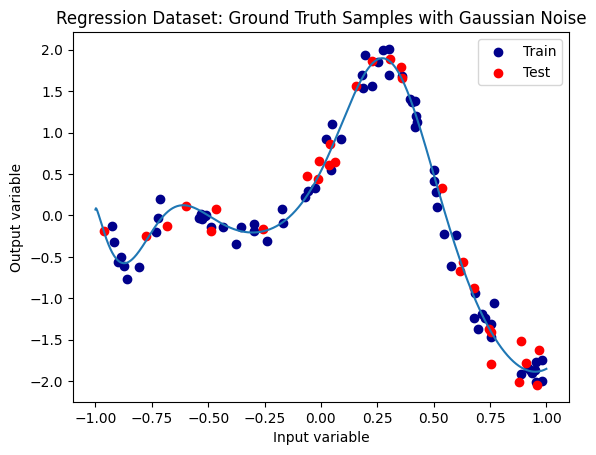

In [4]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [5]:
x_tr

tensor([[-0.4334],
        [ 0.2272],
        [ 0.9379],
        [-0.9199],
        [-0.7217],
        [-0.5335],
        [ 0.3614],
        [ 0.0230],
        [ 0.5776],
        [ 0.9479],
        [ 0.5135],
        [ 0.4054],
        [-0.2973],
        [ 0.3934],
        [ 0.4274],
        [-0.8879],
        [ 0.4995],
        [ 0.0450],
        [-0.7117],
        [ 0.1872],
        [-0.5395],
        [ 0.9560],
        [-0.3774],
        [ 0.6817],
        [-0.1672],
        [ 0.3013],
        [-0.5255],
        [-0.8058],
        [-0.8719],
        [ 0.5996],
        [-0.8619],
        [ 0.0911],
        [-0.9259],
        [-0.5155],
        [ 0.2533],
        [-0.3554],
        [-0.7317],
        [ 0.7558],
        [ 0.7297],
        [-0.5075],
        [ 0.8879],
        [ 0.6777],
        [ 0.7538],
        [-0.0711],
        [-0.8999],
        [ 0.1952],
        [ 0.5095],
        [ 0.1812],
        [ 0.4995],
        [ 0.9820],
        [ 0.6957],
        [ 0.2733],
        [ 0.

### Plot BNN Prior in Function Space

C:\Users\peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[-0.00523019 -0.00523003 -0.00522987 -0.00522972 -0.00522955 -0.00522935
 -0.00522915 -0.00522894 -0.00522873 -0.00522853 -0.00522833 -0.00522812
 -0.00522792 -0.00522777 -0.00522762 -0.00522747 -0.00522733 -0.00522716
 -0.00522702 -0.00522686 -0.00522665 -0.00522644 -0.00522623 -0.00522603
 -0.00522582 -0.00522561 -0.0052254  -0.00522519 -0.00522498 -0.00522477
 -0.00522456 -0.00522436 -0.00522415 -0.0052239  -0.00522365 -0.0052234
 -0.00522315 -0.0052229  -0.00522261 -0.00522231 -0.00522208 -0.00522188
 -0.00522162 -0.00522135 -0.00522108 -0.00522081 -0.00522054 -0.00522028
 -0.00522001 -0.00521974 -0.00521945 -0.00521907 -0.00521864 -0.00521821
 -0.00521778 -0.00521735 -0.00521691 -0.00521648 -0.00521605 -0.00521562
 -0.00521519 -0.00521478 -0.00521436 -0.00521393 -0.00521344 -0.00521286
 -0.00521228 -0.00521171 -0.00521113 -0.00521054 -0.00520996 -0.00520937
 -0.00520879 -0.0052082  -0.00520762 -0.00520703 -0.00520645 -0.00520586
 -0.00520528 -0.00520469 -0.00520411 -0.00520352 -0.

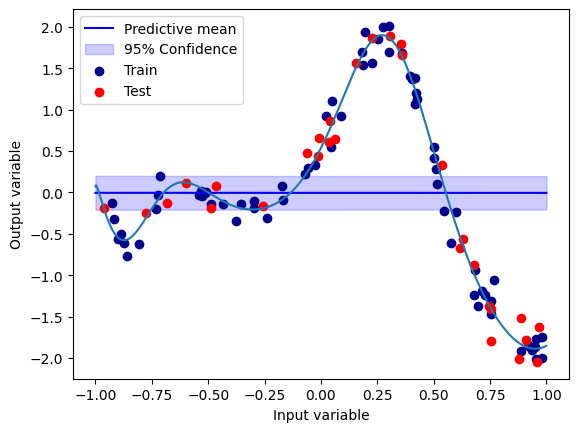

In [6]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 10, 10, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).resize(n_test,1), params_sample).resize(n_test))

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)
    print(pred_mean)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

### Training

Epoch 1
Epoch 2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan na

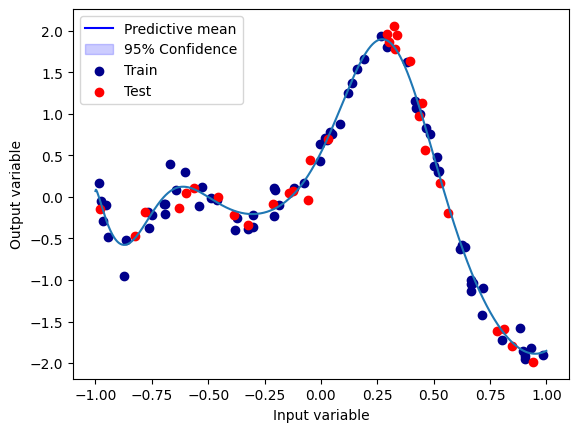

In [ ]:
def compute_param_gradients(net, input, targets, K=500)# sample_std, K=500):
        gradients = torch.zeros(net.num_params, requires_grad=False)
        for k in range(K):
            sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
            output = net.forward(input, sampled_params)  # Forward pass
            output.backward(torch.ones(output.shape[0]).resize(output.shape[0], 1))  # Backpropagate to calculate gradients
            net_grads = sampled_params.grad
            del_ll_f = 1/std_noise**2 (targets - output) # we haven't assigned noise yet, it is tuneable
            
            del_log_prior = net.prior_cov_inv @ (sampled_params - net.prior_mean)
            g_k = -del_log_prior - 1/(sample_std**2) * (targets - output).sum() * net_grads
            gradients += g_k

        return 1/K * gradients


def update_variational_params(net, input, targets, sample_std=0.1, K=500):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, sample_std, K).resize(n, 1)
    g_tp = g.resize(1, n)

    with torch.no_grad():
        mu, chol = net.mean.resize(n,1), net.cov_chol
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.resize(n,1)
        factor = torch.sqrt(torch.tensor([1 / (1-alpha*gamma)]))
        chol = factor * chol

        v = chol @ (chol.t() @ g)
        beta = - alpha / (1 + alpha * g_tp @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(factor * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = factor * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(factor) * chol[k,j]
                chol_new[k,j] = torch.sqrt(factor) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(factor * chol[j,j]**2)
        
        nu = g_tp @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g

    net.mean = nn.Parameter((chol_new @ (torch.transpose(chol_new, 0, 1) @ lambda_1)).resize(n), requires_grad=False) # might need to be true
    net.cov_chol = nn.Parameter(chol_new, requires_grad = False) # same here


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 2
sample_std = 0.1

for epoch in range(n_epochs):

    print(f'Epoch {epoch+1}')
    update_variational_params(BNN, x_tr, y_tr, sample_std=0.1, K=100)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
    

